In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_matrices(*correlation_matrices, titles=None, cmap='viridis', organ_names_dict=None, remove_diagonal=False, triangular=False, annot=False):
    """
    Plots multiple matrices (NumPy arrays) in a row as subplots with a shared color scale and adjusted axis labels.

    Args:
        *correlation_matrices: Variable number of NumPy arrays (correlation matrices).
        titles: Optional list of titles for each correlogram. If None, default titles are used.
        cmap: Optional colormap for the heatmaps.
        organ_names_dict: Optional dictionary mapping indices to organ names. If provided, axis labels are adjusted.
    """

    num_matrices = len(correlation_matrices)

    if num_matrices == 0:
        print("No correlation matrices provided.")
        return

    if titles is None:
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]
    elif len(titles) != num_matrices:
        print("Number of titles does not match number of matrices.")
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]

    # Find the global min and max for the color scale
    global_min = min(np.nanmin(corr_matrix) for corr_matrix in correlation_matrices)
    global_max = max(np.nanmax(corr_matrix) for corr_matrix in correlation_matrices)

    if num_matrices == 1:
        plt.figure(figsize=(8 + 2*(organ_names_dict is not None), 8 + 2*(organ_names_dict is not None)))
    else:
        plt.figure(figsize=(12 * num_matrices, 12))

    for i, corr_matrix in enumerate(correlation_matrices):
        if remove_diagonal:
            np.fill_diagonal(corr_matrix, np.nan)
        if triangular:
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        else:
            mask = False

        plt.subplot(1, num_matrices, i + 1)
        ax = sns.heatmap(
            corr_matrix,
            annot=annot,
            cmap=cmap,
            fmt='.2f',
            linewidths=0,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 12},
            square=True,
            linecolor='white',
            vmin=global_min,  # Set global min
            vmax=global_max,   # Set global max
            mask=mask
        )
        plt.title(titles[i])

        if organ_names_dict is not None:
            num_organs = corr_matrix.shape[0]
            if len(organ_names_dict) == num_organs:
                organ_names = [organ_names_dict.get(j, f"Index {j}") for j in range(num_organs)]
                ax.set_xticks(np.array(range(num_organs))+0.5)
                ax.set_xticklabels(organ_names, rotation=90)
                ax.set_yticks(np.array(range(num_organs))+0.5)
                ax.set_yticklabels(organ_names, rotation=0)
            else:
                print(f"Warning: Length of organ_names_dict ({len(organ_names_dict)}) does not match matrix size ({num_organs}).")

    plt.tight_layout()
    plt.show()

Generating Erdos-Renyi graphs...
Creating Graph VAE model...
Training model...
Epoch 10/100, Loss: 83.6093
Epoch 20/100, Loss: 78.5854
Epoch 30/100, Loss: 76.6446
Epoch 40/100, Loss: 75.5391
Epoch 50/100, Loss: 74.9035
Epoch 60/100, Loss: 74.3613
Epoch 70/100, Loss: 73.9406
Epoch 80/100, Loss: 73.8287
Epoch 90/100, Loss: 73.4146
Epoch 100/100, Loss: 73.2274
Visualizing results...


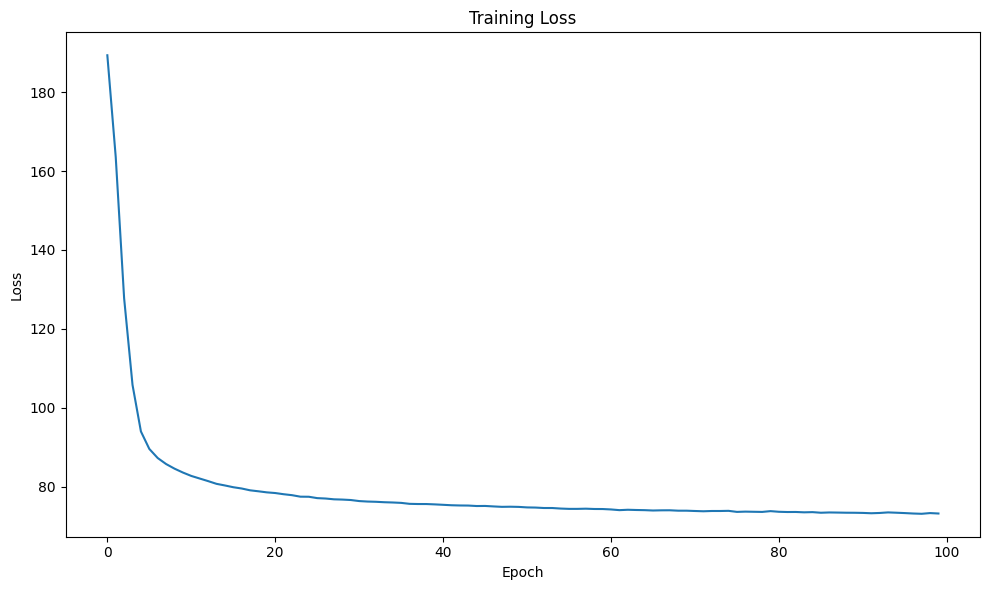

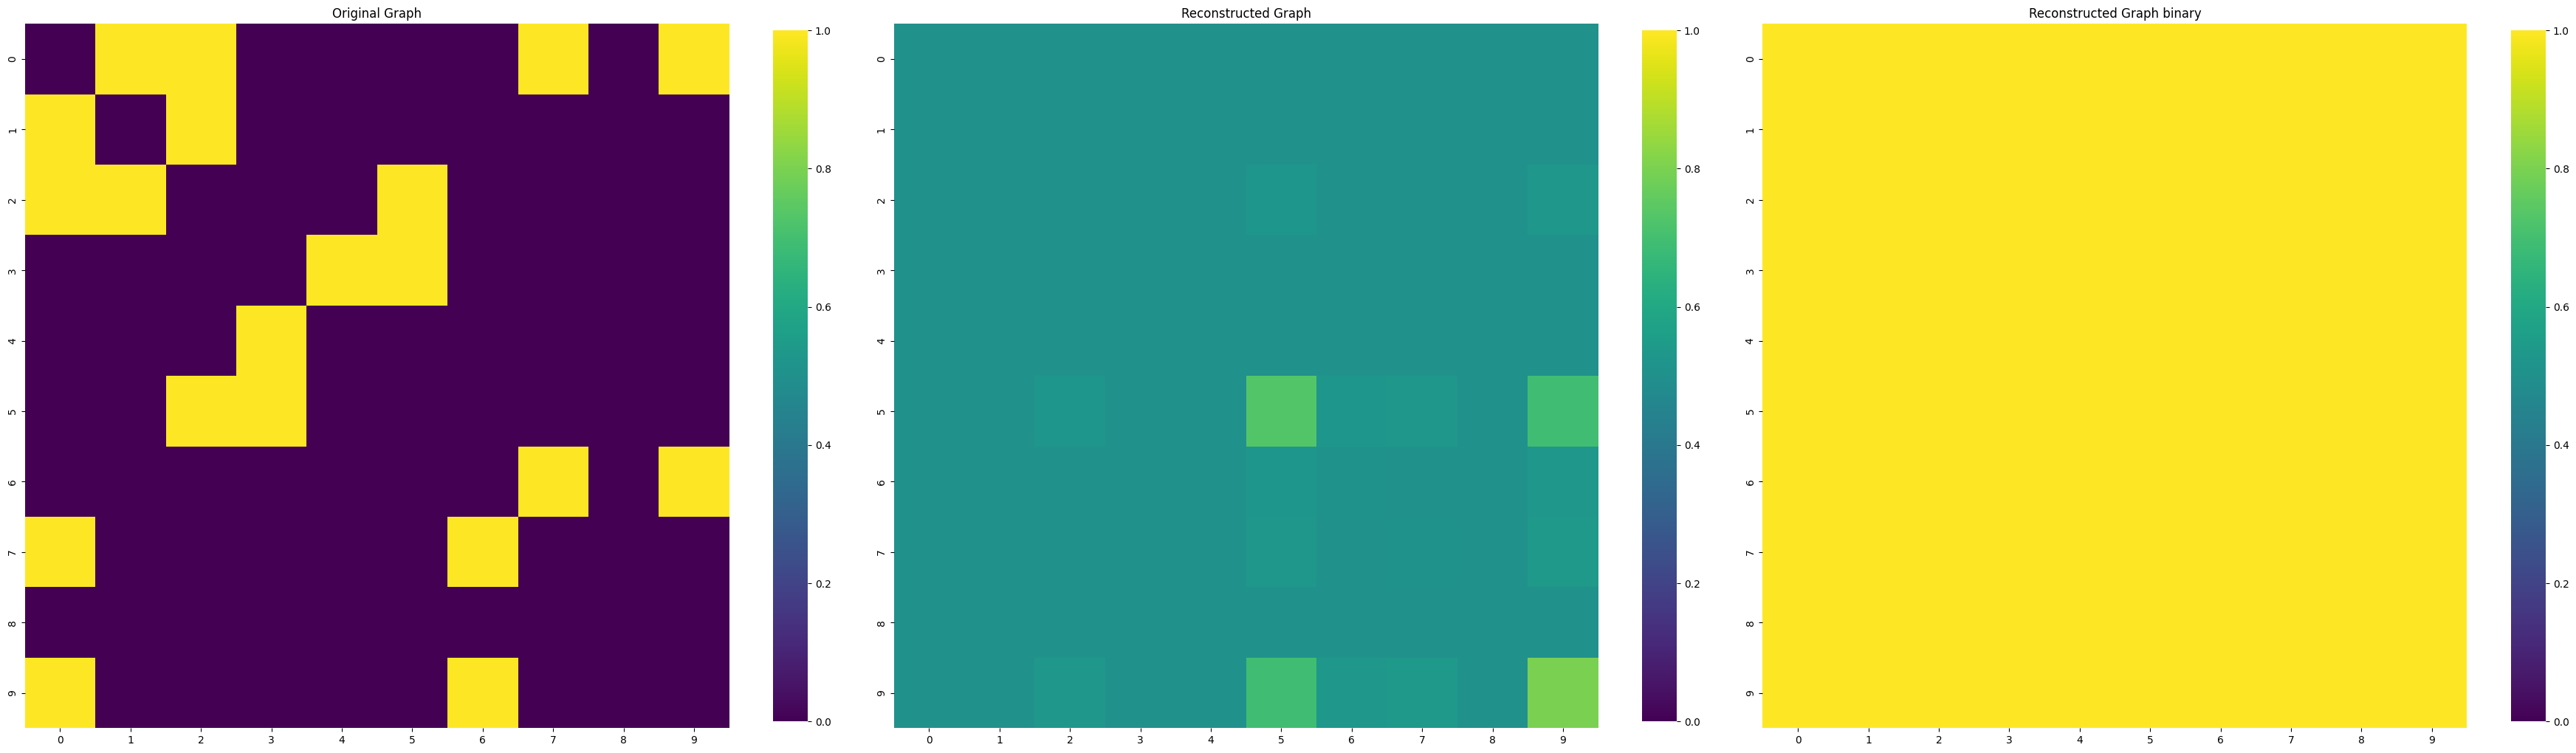

Generating new graphs from latent space...


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_71681/1106667416.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


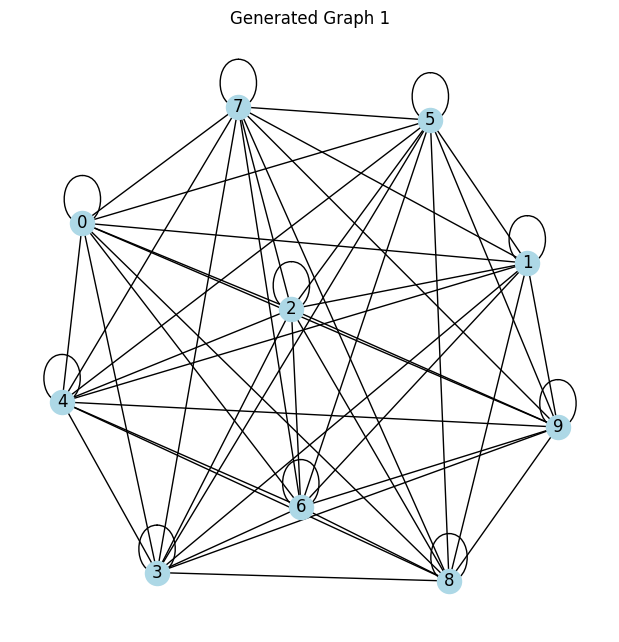

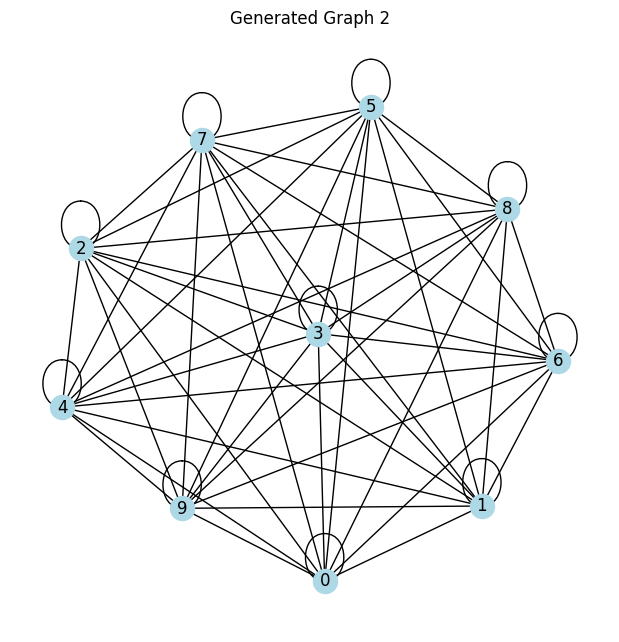

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to generate Erdos-Renyi graphs
def generate_erdos_renyi_graphs(num_graphs, n_nodes, p_edge):
    """
    Generate a batch of Erdos-Renyi graphs.
    
    Args:
        num_graphs: Number of graphs to generate
        n_nodes: Number of nodes in each graph
        p_edge: Probability of edge creation
        
    Returns:
        List of adjacency matrices
    """
    graphs = []
    for _ in range(num_graphs):
        # Generate a random adjacency matrix
        adj = np.random.binomial(1, p_edge, (n_nodes, n_nodes))
        # Make the graph undirected (symmetric adjacency matrix)
        adj = np.triu(adj, k=1)
        adj = adj + adj.T
        # Remove self-loops
        np.fill_diagonal(adj, 0)
        graphs.append(adj)
    return np.array(graphs)

# Preprocessing functions
def preprocess_adjacency(adj):
    """
    Calculate normalized adjacency matrix: A_hat = D^(-1/2) * (A + I) * D^(-1/2)
    """
    adj_normalized = []
    for i in range(adj.shape[0]):
        # Add self-connections
        adj_tilde = adj[i] + np.eye(adj[i].shape[0])
        # Compute degree matrix
        d_tilde_diag = np.sum(adj_tilde, axis=1)
        # Compute D^(-1/2)
        d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -0.5)
        d_tilde_inv_sqrt_diag[np.isinf(d_tilde_inv_sqrt_diag)] = 0.0
        d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
        # Compute normalized adjacency
        adj_normalized.append(
            d_tilde_inv_sqrt @ adj_tilde @ d_tilde_inv_sqrt
        )
    return np.array(adj_normalized)

# Graph Convolutional Layer
class GraphConvolution(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        # Build weights for the layer
        self.weight = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name='weight'
        )
        self.bias = self.add_weight(
            shape=(self.units,), 
            initializer="zeros", 
            trainable=True,
            name='bias'
        )
        super(GraphConvolution, self).build(input_shape)
        
    def call(self, inputs):
        features, adj = inputs
        # Graph convolution operation: A_hat * X * W
        output = tf.matmul(adj, features)
        output = tf.matmul(output, self.weight) + self.bias
        return output
    
    def get_config(self):
        config = super(GraphConvolution, self).get_config()
        config.update({"units": self.units})
        return config

# Define individual encoder and decoder components to avoid recursion
class GraphEncoder(layers.Layer):
    def __init__(self, hidden_dim=32, latent_dim=16, **kwargs):
        super(GraphEncoder, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.graph_conv1 = GraphConvolution(hidden_dim)
        self.graph_conv1bis = GraphConvolution(hidden_dim)
        self.graph_conv1ter = GraphConvolution(hidden_dim)
        self.graph_conv2_mean = GraphConvolution(latent_dim)
        self.graph_conv2_logvar = GraphConvolution(latent_dim)
    
    def call(self, inputs):
        features, adj_normalized = inputs
        
        # First GCN layer
        h = tf.nn.relu(self.graph_conv1([features, adj_normalized]))
        h = tf.nn.relu(self.graph_conv1bis([h, adj_normalized]))
        h = tf.nn.relu(self.graph_conv1ter([h, adj_normalized]))
        
        # Mean and log variance
        z_mean = self.graph_conv2_mean([h, adj_normalized])
        z_log_var = self.graph_conv2_logvar([h, adj_normalized])
        
        return z_mean, z_log_var

class GraphDecoder(layers.Layer):
    def __init__(self, n_nodes, **kwargs):
        super(GraphDecoder, self).__init__(**kwargs)
        self.n_nodes = n_nodes
        
        # Final projection layer
        self.dense = layers.Dense(n_nodes, activation='sigmoid')
    
    def call(self, z):
        # Project nodes to output space
        node_embeddings = self.dense(z)
        
        # Compute adjacency via inner product
        logits = tf.matmul(node_embeddings, node_embeddings, transpose_b=True)
        
        # Make symmetric for undirected graphs
        logits = 0.5 * (logits + tf.transpose(logits, perm=[0, 2, 1]))
        
        # Apply sigmoid for probabilities
        adj_recon = tf.nn.sigmoid(logits)
        
        return adj_recon

class GVAE(Model):
    def __init__(self, n_nodes, hidden_dim=32, latent_dim=16, **kwargs):
        super(GVAE, self).__init__(**kwargs)
        self.n_nodes = n_nodes
        self.latent_dim = latent_dim
        
        # Create encoder and decoder
        self.encoder = GraphEncoder(hidden_dim, latent_dim)
        self.decoder = GraphDecoder(n_nodes)
    
    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        nodes = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, nodes, self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def call(self, inputs):
        # Unpack inputs
        adj, adj_normalized, features = inputs
        
        # Convert adjacency matrix to float32
        adj = tf.cast(adj, tf.float32)
        
        # Encode
        z_mean, z_log_var = self.encoder([features, adj_normalized])
        
        # Reparameterize
        z = self.reparameterize(z_mean, z_log_var)
        
        # Decode
        adj_recon = self.decoder(z)
        
        # Calculate losses
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 
                axis=-1
            )
        )
        
        # Element-wise binary cross-entropy
        epsilon = 1e-7  # Small constant to avoid log(0)
        reconstruction_loss = -tf.reduce_mean(
            tf.reduce_sum(
                adj * tf.math.log(adj_recon + epsilon) + 
                (1 - adj) * tf.math.log(1 - adj_recon + epsilon),
                axis=[1, 2]
            )
        )
        
        # Add losses to the model
        self.add_loss(kl_loss)
        self.add_loss(reconstruction_loss)
        
        return adj_recon
    
    # Method to encode input graphs
    def encode(self, adj_normalized, features):
        return self.encoder([features, adj_normalized])
    
    # Method to decode latent vectors
    def decode_z(self, z):
        return self.decoder(z)

# Training function with eager execution
def train_gvae(model, train_data, epochs=100, batch_size=32):
    optimizer = Adam(learning_rate=0.001)
    
    # Create features (identity matrix replicated for each graph)
    n_nodes = train_data.shape[1]
    features = np.tile(np.expand_dims(np.eye(n_nodes), 0), (len(train_data), 1, 1))
    
    # Preprocess adjacency matrices
    normalized_adj = preprocess_adjacency(train_data)
    
    # Training loop
    history = {"loss": []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        # Create batches
        indices = np.random.permutation(len(train_data))
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            if len(batch_indices) < 2:  # Skip last batch if too small
                continue
                
            batch_graphs = train_data[batch_indices]
            batch_normalized = normalized_adj[batch_indices]
            batch_features = features[batch_indices]
            
            # Forward pass and backpropagation
            with tf.GradientTape() as tape:
                # Run forward pass
                _ = model([batch_graphs, batch_normalized, batch_features])
                # Get loss (sum of all model losses)
                loss = sum(model.losses)
            
            # Clear the losses for next batch
            model.reset_metrics()
            
            # Compute and apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss += loss.numpy()
            num_batches += 1
        
        if num_batches > 0:
            epoch_loss /= num_batches
            history["loss"].append(epoch_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    return history

# Visualization functions
def visualize_graph(adj_matrix, title):
    G = nx.from_numpy_array(adj_matrix)
    plt.figure(figsize=(6, 6))
    nx.draw(G, node_size=300, with_labels=True, node_color="lightblue")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def visualize_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history["loss"])
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

# Main pipeline
def run_gvae_pipeline(n_nodes=10, n_graphs=500, p_edge=0.3, epochs=50):
    # 1. Generate synthetic graph data
    print("Generating Erdos-Renyi graphs...")
    graph_data = generate_erdos_renyi_graphs(n_graphs, n_nodes, p_edge)
    
    # 2. Create the model
    print("Creating Graph VAE model...")
    model = GVAE(n_nodes=n_nodes, hidden_dim=64, latent_dim=2)
    
    # Compile the model (with empty optimizer to initialize it)
    model.compile(optimizer='adam')
    
    # Initialize with a single forward pass
    sample_data = graph_data[:2]
    sample_normalized = preprocess_adjacency(sample_data)
    sample_features = np.tile(np.expand_dims(np.eye(n_nodes), 0), (2, 1, 1))
    _ = model([sample_data, sample_normalized, sample_features])
    
    # 3. Train the model
    print("Training model...")
    history = train_gvae(model, graph_data, epochs=epochs)
    
    # 4. Visualize results
    print("Visualizing results...")
    visualize_loss(history)
    
    # 5. Test on a sample graph
    test_graph = graph_data[0]
    test_normalized = preprocess_adjacency(np.expand_dims(test_graph, 0))[0]
    test_features = np.eye(n_nodes)
    
    # Visualize original graph
    #visualize_graph(test_graph, "Original Graph")
    
    # Run inference
    recon_graph = model([
        np.expand_dims(test_graph, 0),
        np.expand_dims(test_normalized, 0),
        np.expand_dims(test_features, 0)
    ])
    
    # Convert to numpy and threshold
    recon_graph = recon_graph.numpy()[0]
    recon_graph_binary = (recon_graph > 0.5).astype(np.int32)
    
    # Visualize reconstructed graph
    #visualize_graph(recon_graph_binary, "Reconstructed Graph")
    plot_matrices(test_graph, recon_graph, recon_graph_binary, titles=["Original Graph", "Reconstructed Graph", "Reconstructed Graph binary"])
    
    # Generate new graphs from latent space
    print("Generating new graphs from latent space...")
    
    # Create a random latent vector
    random_z = tf.random.normal((3, n_nodes, 16))
    
    # Decode to get new graphs
    new_graphs = model.decode_z(random_z).numpy()
    
    # Visualize generated graphs
    for i in range(2):
        new_graph_binary = (new_graphs[i] > 0.5).astype(np.int32)
        visualize_graph(new_graph_binary, f"Generated Graph {i+1}")
    
    return model, history

# Run the pipeline if the script is executed directly
if __name__ == "__main__":
    n_nodes = 10
    model, history = run_gvae_pipeline(n_nodes=n_nodes, n_graphs=500, epochs=100)

Generating Erdos-Renyi graphs...
Creating Graph VAE model...
Model initialized with sample data.


Model: "gvae_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ graph_encoder_31 (GraphEncoder) │ ?                      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_decoder_31 (GraphDecoder) │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144 (576.00 B)

 Trainable params: 144 (576.00 B)

 Non-trainable params: 0 (0.00 B)


Average proportion of correctly predicted edges before training: 0.5777
Training model...
Using optimizer from model.compile: Adam
Epoch 10/300, Loss (Weighted Total): 27.1706, KL (Unweighted): 19.1393, Recon: 25.2567
Epoch 20/300, Loss (Weighted Total): 27.2447, KL (Unweighted): 17.7114, Recon: 25.4736
Epoch 30/300, Loss (Weighted Total): 26.1636, KL (Unweighted): 16.5366, Recon: 24.5099
Epoch 40/300, Loss (Weighted Total): 24.1555, KL (Unweighted): 15.4903, Recon: 22.6065
Epoch 50/300, Loss (Weighted Total): 23.1441, KL (Unweighted): 14.5480, Recon: 21.6893
Epoch 60/300, Loss (Weighted Total): 22.1561, KL (Unweighted): 13.6671, Recon: 20.7894
Epoch 70/300, Loss (Weighted Total): 21.1438, KL (Unweighted): 12.7764, Recon: 19.8661
Epoch 80/300, Loss (Weighted Total): 21.0265, KL (Unweighted): 11.9768, Recon: 19.8288
Epoch 90/300, Loss (Weighted Total): 19.4729, KL (Unweighted): 11.1750, Recon: 18.3554
Epoch 100/300, Loss (Weighted Total): 19.0938, KL (Unweighted): 10.4795, Recon: 18.04

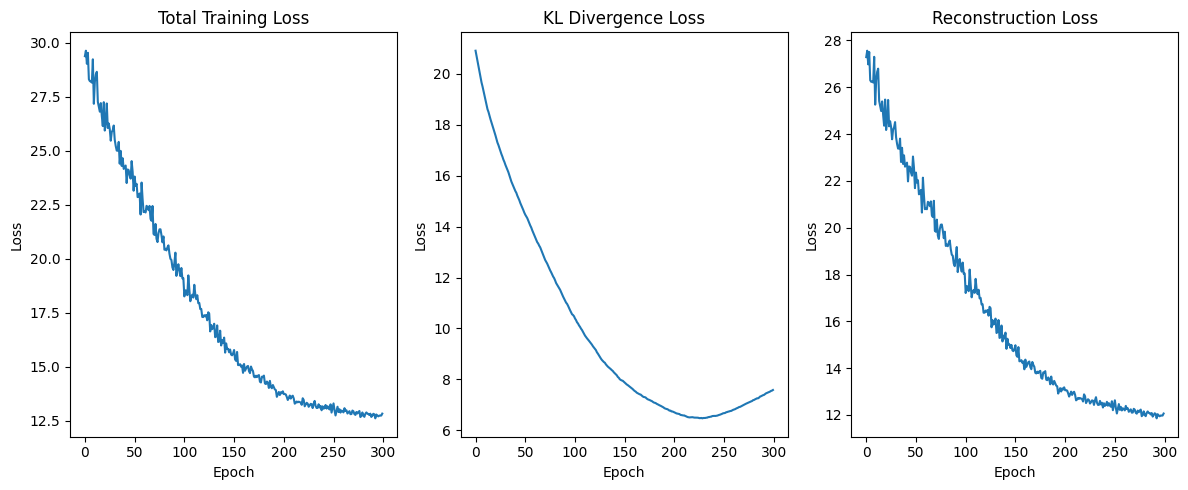

/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_71681/1197662030.py:305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


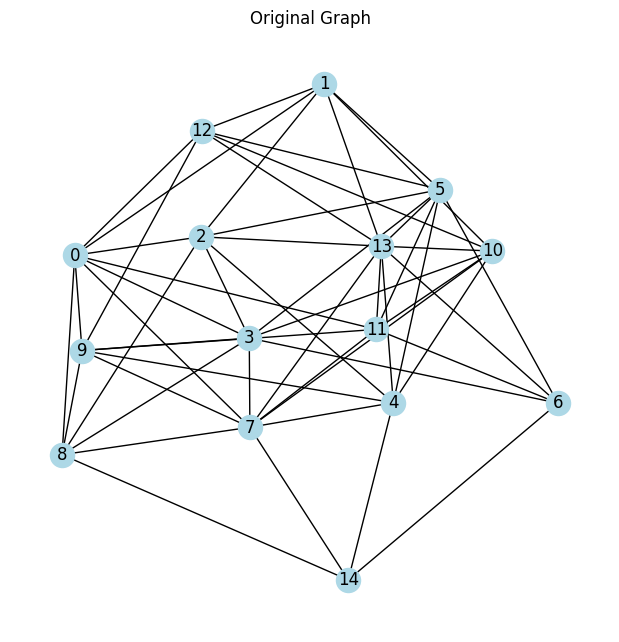

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
DEBUG: Shape of recon_graph_probs before plot_matrices: (15, 15)


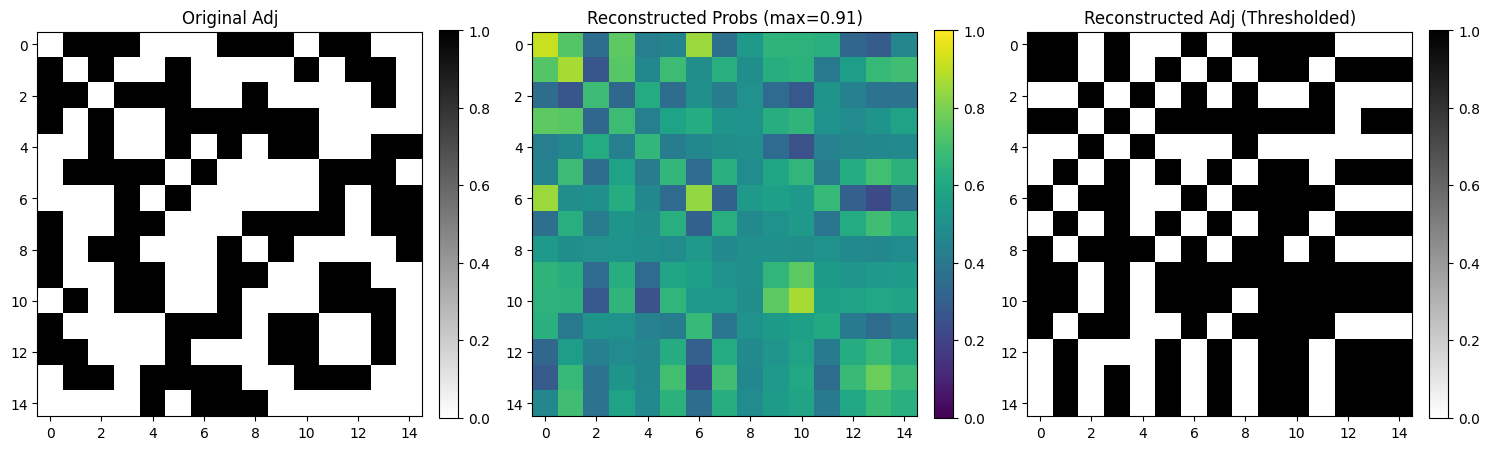

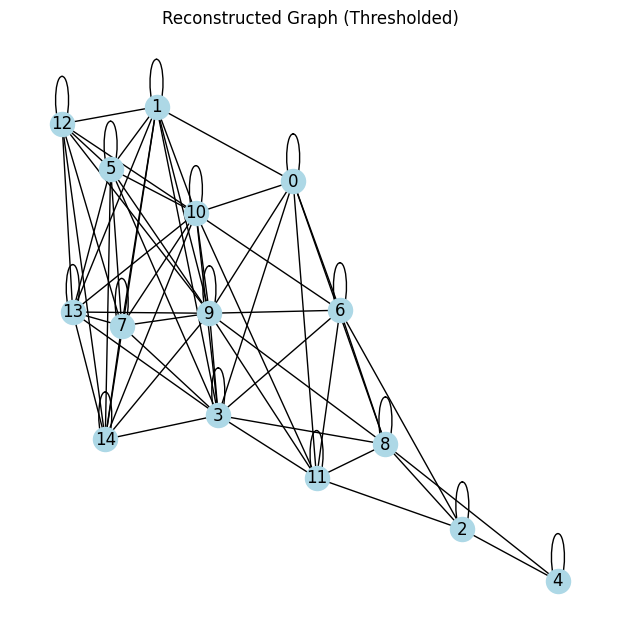

Generating new graphs from latent space...


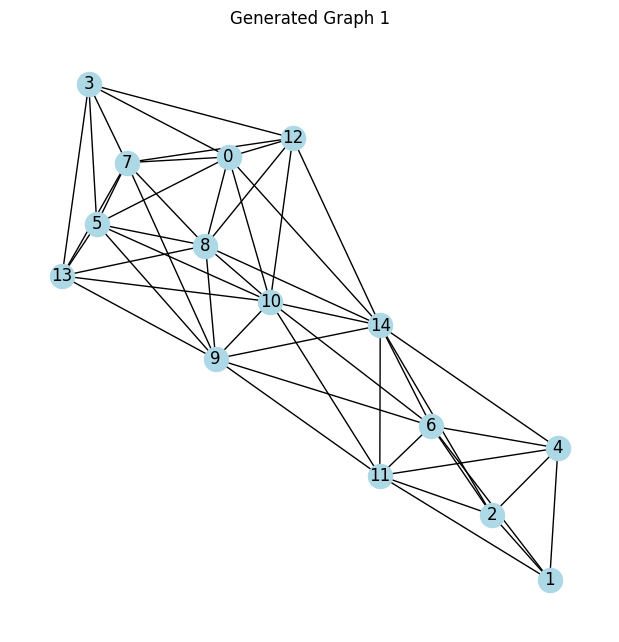

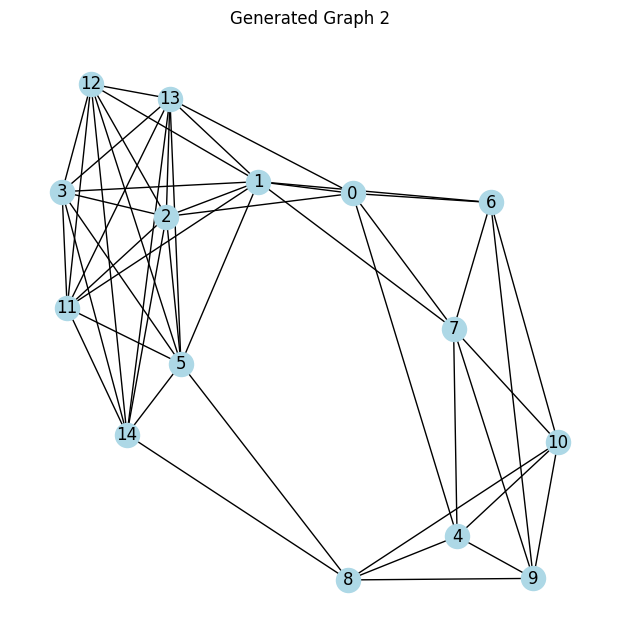

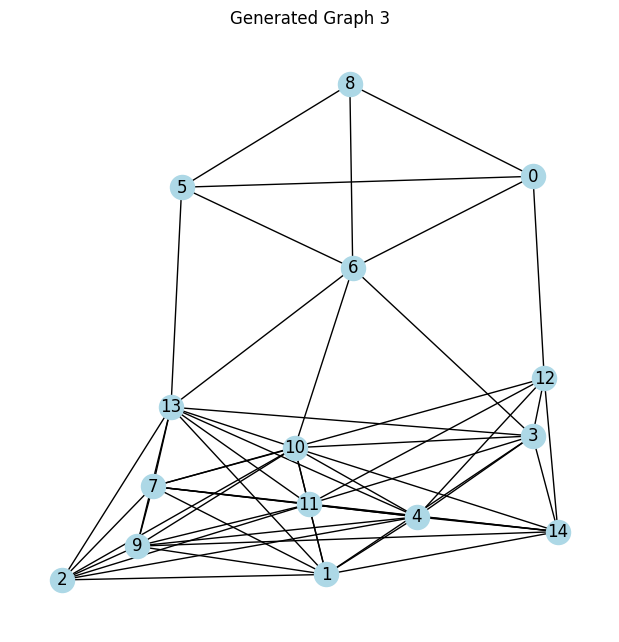


Average proportion of correctly predicted edges after training: 0.5746


In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to generate Erdos-Renyi graphs
def generate_erdos_renyi_graphs(num_graphs, n_nodes, p_edge):
    """
    Generate a batch of Erdos-Renyi graphs.

    Args:
        num_graphs: Number of graphs to generate
        n_nodes: Number of nodes in each graph
        p_edge: Probability of edge creation

    Returns:
        List of adjacency matrices
    """
    graphs = []
    for _ in range(num_graphs):
        # Generate a random adjacency matrix
        adj = np.random.binomial(1, p_edge, (n_nodes, n_nodes))
        # Make the graph undirected (symmetric adjacency matrix)
        adj = np.triu(adj, k=1)
        adj = adj + adj.T
        # Remove self-loops
        np.fill_diagonal(adj, 0)
        graphs.append(adj)
    return np.array(graphs)

# Preprocessing functions
def preprocess_adjacency(adj):
    """
    Calculate normalized adjacency matrix: A_hat = D^(-1/2) * (A + I) * D^(-1/2)
    """
    adj_normalized = []
    for i in range(adj.shape[0]):
        # Add self-connections
        adj_tilde = adj[i] + np.eye(adj[i].shape[0])
        # Compute degree matrix
        d_tilde_diag = np.sum(adj_tilde, axis=1)
        # Compute D^(-1/2)
        d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -0.5)
        d_tilde_inv_sqrt_diag[np.isinf(d_tilde_inv_sqrt_diag)] = 0.0
        d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
        # Compute normalized adjacency
        adj_normalized.append(
            d_tilde_inv_sqrt @ adj_tilde @ d_tilde_inv_sqrt
        )
    return np.array(adj_normalized)

# Graph Convolutional Layer
class GraphConvolution(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Build weights for the layer
        # input_shape[0][-1] is the feature dimension (will be 1 for degrees)
        self.weight = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name='weight'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name='bias'
        )
        super(GraphConvolution, self).build(input_shape)

    def call(self, inputs):
        features, adj = inputs
        # Graph convolution operation: A_hat * X * W
        output = tf.matmul(adj, features)
        output = tf.matmul(output, self.weight) + self.bias
        return output

    def get_config(self):
        config = super(GraphConvolution, self).get_config()
        config.update({"units": self.units})
        return config

# Define individual encoder and decoder components to avoid recursion
class GraphEncoder(layers.Layer):
    def __init__(self, hidden_dim=32, latent_dim=16, **kwargs):
        super(GraphEncoder, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.graph_conv1 = GraphConvolution(hidden_dim*2)
        self.graph_conv1bis = GraphConvolution(hidden_dim)
        self.graph_conv2_mean = GraphConvolution(latent_dim)
        self.graph_conv2_logvar = GraphConvolution(latent_dim)

    def call(self, inputs):
        features, adj_normalized = inputs

        # First GCN layer
        h = tf.nn.tanh(self.graph_conv1([features, adj_normalized]))
        h = tf.nn.tanh(self.graph_conv1bis([h, adj_normalized]))

        # Mean and log variance
        z_mean = self.graph_conv2_mean([h, adj_normalized])
        z_log_var = self.graph_conv2_logvar([h, adj_normalized])

        return z_mean, z_log_var

class GraphDecoder(layers.Layer):
    def __init__(self, n_nodes, **kwargs):
        super(GraphDecoder, self).__init__(**kwargs)
        self.n_nodes = n_nodes

        # Inner product decoder - no explicit dense layer needed here
        # The latent vectors 'z' directly represent node embeddings

    def call(self, z):
        # Compute adjacency probabilities via inner product of latent embeddings
        # z has shape (batch, n_nodes, latent_dim)
        logits = tf.matmul(z, z, transpose_b=True) # Shape: (batch, n_nodes, n_nodes)

        # Make symmetric for undirected graphs (optional but good practice)
        # logits = 0.5 * (logits + tf.transpose(logits, perm=[0, 2, 1]))

        # Apply sigmoid for probabilities
        adj_recon = tf.nn.sigmoid(logits)

        return adj_recon

class GVAE(Model):
    def __init__(self, n_nodes, hidden_dim=32, latent_dim=16, **kwargs):
        super(GVAE, self).__init__(**kwargs)
        self.n_nodes = n_nodes
        self.latent_dim = latent_dim

        # Create encoder and decoder
        self.encoder = GraphEncoder(hidden_dim, latent_dim)
        self.decoder = GraphDecoder(n_nodes) # Decoder only needs n_nodes for potential checks, not layers

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        nodes = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, nodes, self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        # Unpack inputs
        adj, adj_normalized, features = inputs

        # Convert adjacency matrix to float32
        adj = tf.cast(adj, tf.float32)
        # Convert features to float32 (important!)
        features = tf.cast(features, tf.float32)

        # Encode
        z_mean, z_log_var = self.encoder([features, adj_normalized])

        # Reparameterize
        z = self.reparameterize(z_mean, z_log_var)

        # Decode
        adj_recon = self.decoder(z)

        # --- Calculate losses ---
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=[1, 2] # Sum over nodes and latent dimensions
            )
        )

        # Reconstruction loss (binary cross-entropy)
        epsilon = 1e-7  # Small constant to avoid log(0)
        bce_matrix = binary_crossentropy(tf.cast(adj, tf.float32), adj_recon) # Shape (batch, n_nodes)
        bce_per_graph = tf.reduce_sum(bce_matrix, axis=1) # Sum over the last dimension (nodes) # Shape: (batch,)
        reconstruction_loss = tf.reduce_mean(bce_per_graph) # Shape: scalar

        # --- Add losses FOR GRADIENTS (this is still needed) ---
        # Apply KL weight here if desired
        kl_weight = 0.1 # Example weight
        self.add_loss(kl_loss * kl_weight) # Add weighted KL loss
        self.add_loss(reconstruction_loss) # Add Reconstruction loss

        # --- REMOVE DEPRECATED METRIC ADDING ---
        # self.add_metric(kl_loss, name='kl_loss') # REMOVE THIS LINE
        # self.add_metric(reconstruction_loss, name='recon_loss') # REMOVE THIS LINE

        # --- RETURN reconstruction AND INDIVIDUAL LOSSES for tracking ---
        return adj_recon, kl_loss, reconstruction_loss # Modified return

    # Method to encode input graphs
    def encode(self, adj_normalized, features):
         # Convert features to float32 (important!)
        features = tf.cast(features, tf.float32)
        return self.encoder([features, adj_normalized])

    # Method to decode latent vectors
    def decode_z(self, z):
        return self.decoder(z)

# Training function with eager execution
# Training function with eager execution
def train_gvae(model, train_data, epochs=100, batch_size=16):
    # Use the optimizer configured in model.compile if available, or define one
    if model.optimizer is None:
         optimizer = Adam(learning_rate=0.001)
         print("Using default Adam optimizer in train_gvae")
    else:
         optimizer = model.optimizer # Use the one from compile
         print(f"Using optimizer from model.compile: {type(optimizer).__name__}")


    # Calculate degree features
    n_nodes = train_data.shape[1]
    degrees = np.sum(train_data, axis=2)
    features = np.expand_dims(degrees, axis=-1).astype(np.float32)
    # print(f"Using node degrees as features. Feature shape: {features.shape}") # Optional print

    # Preprocess adjacency matrices
    normalized_adj = preprocess_adjacency(train_data)

    # Training loop
    history = {"loss": [], "kl_loss": [], "recon_loss": []}

    for epoch in range(epochs):
        epoch_total_loss_sum = 0
        epoch_kl_sum = 0
        epoch_recon_sum = 0
        num_batches = 0

        # Create batches
        indices = np.random.permutation(len(train_data))

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            if len(batch_indices) < 2:
                continue

            batch_graphs = train_data[batch_indices]
            batch_normalized = normalized_adj[batch_indices]
            batch_features = features[batch_indices]

            # Forward pass and backpropagation
            with tf.GradientTape() as tape:
                # --- CORRECTED MODEL CALL ---
                # Model call now returns: adj_recon, kl_loss, reconstruction_loss
                adj_recon_batch, kl_loss_batch, recon_loss_batch = model(
                    [batch_graphs, batch_normalized, batch_features], training=True
                )

                # Get total loss (sum of losses added via self.add_loss in GVAE.call)
                # This includes the weighted KL loss
                loss = sum(model.losses)

            # Compute and apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Clip gradients if necessary (optional)
            # gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients if grad is not None]
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # --- CORRECTED LOSS ACCUMULATION ---
            # Accumulate using the values RETURNED by the model call
            epoch_total_loss_sum += loss.numpy()
            epoch_kl_sum += kl_loss_batch.numpy()       # Use returned kl_loss
            epoch_recon_sum += recon_loss_batch.numpy() # Use returned recon_loss

            # --- REMOVED METRIC RESET ---
            # model.reset_metrics() # Ensure this line is removed or commented out

            num_batches += 1

        if num_batches > 0:
            avg_loss = epoch_total_loss_sum / num_batches
            avg_kl = epoch_kl_sum / num_batches
            avg_recon = epoch_recon_sum / num_batches

            history["loss"].append(avg_loss)
            history["kl_loss"].append(avg_kl)
            history["recon_loss"].append(avg_recon)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss (Weighted Total): {avg_loss:.4f}, KL (Unweighted): {avg_kl:.4f}, Recon: {avg_recon:.4f}")

    return history


# Visualization functions
def visualize_graph(adj_matrix, title):
    G = nx.from_numpy_array(adj_matrix)
    plt.figure(figsize=(6, 6))
    nx.draw(G, node_size=300, with_labels=True, node_color="lightblue", pos=nx.spring_layout(G, seed=42)) # Use layout for consistency
    plt.title(title)
    plt.tight_layout()
    plt.show()

def visualize_loss(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history["loss"])
    plt.title("Total Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(history["kl_loss"])
    plt.title("KL Divergence Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(history["recon_loss"])
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

def plot_matrices(mat1, mat2, mat3, titles):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im1 = axes[0].imshow(mat1, cmap='binary', vmin=0, vmax=1)
    axes[0].set_title(titles[0])
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    im2 = axes[1].imshow(mat2, cmap='viridis', vmin=0, vmax=1) # Use different map for probabilities
    axes[1].set_title(titles[1] + f" (max={mat2.max():.2f})")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    im3 = axes[2].imshow(mat3, cmap='binary', vmin=0, vmax=1)
    axes[2].set_title(titles[2])
    fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

def compute_avg_correct_edge_predictions(model, graphs, threshold=0.5):
    n_graphs = graphs.shape[0]
    n_nodes = graphs.shape[1]

    normalized_adjs = preprocess_adjacency(graphs)
    degrees = np.sum(graphs, axis=2)
    features = np.expand_dims(degrees, axis=-1).astype(np.float32)

    correct_predictions = []

    for i in range(n_graphs):
        adj_true = graphs[i]
        adj_norm = normalized_adjs[i]
        feat = features[i]

        # Run prediction
        adj_pred_probs = model.predict([np.expand_dims(adj_true, 0),
                                        np.expand_dims(adj_norm, 0),
                                        np.expand_dims(feat, 0)], verbose=0)[0]

        adj_pred_binary = (adj_pred_probs > threshold).astype(np.int32)[0]


        # Remove self-loops for comparison
        np.fill_diagonal(adj_true, 0)
        np.fill_diagonal(adj_pred_binary, 0)

        # Count correctly predicted edges (both 0s and 1s)
        correct = np.sum(adj_true == adj_pred_binary)
        total = n_nodes * n_nodes - n_nodes  # Total possible edges excluding diagonal
        accuracy = correct / total
        correct_predictions.append(accuracy)

    return np.mean(correct_predictions)

# Main pipeline
def run_gvae_pipeline(n_nodes=10, n_graphs=500, p_edge=0.3, epochs=50):
    # 1. Generate synthetic graph data
    print("Generating Erdos-Renyi graphs...")
    graph_data = generate_erdos_renyi_graphs(n_graphs, n_nodes, p_edge)

    # 2. Create the model
    print("Creating Graph VAE model...")
    model = GVAE(n_nodes=n_nodes, hidden_dim=6, latent_dim=3)

    # Compile the model (required to track metrics added with add_metric)
    model.compile(optimizer=Adam(learning_rate=0.0001)) # Optimizer here is mainly for compilation setup

    # --- CHANGE START: Prepare sample data with degree features for initialization ---
    sample_data = graph_data[:2]
    sample_normalized = preprocess_adjacency(sample_data)
    # Calculate degrees for sample data
    sample_degrees = np.sum(sample_data, axis=2)
    sample_features = np.expand_dims(sample_degrees, axis=-1).astype(np.float32)
    # Initialize model weights/build layers
    _ = model([sample_data, sample_normalized, sample_features])
    print("Model initialized with sample data.")
    model.summary() # Print model summary to see layer shapes
    # --- CHANGE END ---

    # 3. Train the model using the custom training loop
    avg_correct = compute_avg_correct_edge_predictions(model, graph_data)
    print(f"\nAverage proportion of correctly predicted edges before training: {avg_correct:.4f}")

    print("Training model...")
    # We pass the model instance, which is already compiled
    history = train_gvae(model, graph_data, epochs=epochs)

    # 4. Visualize results
    print("Visualizing results...")
    visualize_loss(history)

    # 5. Test on a sample graph
    test_graph = graph_data[0]
    test_normalized = preprocess_adjacency(np.expand_dims(test_graph, 0))[0]
    test_degrees = np.sum(test_graph, axis=1)
    test_features = np.expand_dims(test_degrees, axis=-1).astype(np.float32)

    # Visualize original graph
    visualize_graph(test_graph, "Original Graph")

    # Run inference
    # Use a temporary variable for the batched output
    recon_graph_probs_batched = model.predict([
        np.expand_dims(test_graph, 0),          # Batch dim
        np.expand_dims(test_normalized, 0),     # Batch dim
        np.expand_dims(test_features, 0)        # Batch dim
    ])

    # --- >>> ENSURE THIS LINE EXISTS AND IS NOT COMMENTED OUT <<< ---
    # Remove the batch dimension (index 0) as we only predicted for one graph
    recon_graph_probs = recon_graph_probs_batched[0][0]
    print(f"DEBUG: Shape of recon_graph_probs before plot_matrices: {recon_graph_probs.shape}")
    # --- >>> END CHECK <<< ---

    # Convert to numpy and threshold
    recon_graph_binary = (recon_graph_probs > 0.5).astype(np.int32)

    # Visualize reconstructed graph using matrix plots
    # plot_matrices should now receive recon_graph_probs with shape (15, 15)
    plot_matrices(test_graph, recon_graph_probs, recon_graph_binary,
                  titles=["Original Adj", "Reconstructed Probs", "Reconstructed Adj (Thresholded)"])

    visualize_graph(recon_graph_binary, "Reconstructed Graph (Thresholded)")

    # Generate new graphs from latent space
    print("Generating new graphs from latent space...")

    # Create random latent vectors z (shape: batch, n_nodes, latent_dim)
    num_new_graphs = 3
    random_z = tf.random.normal((num_new_graphs, n_nodes, model.latent_dim))

    # Decode to get new graph adjacency probabilities
    new_graphs_probs = model.decode_z(random_z).numpy()

    # Visualize generated graphs
    for i in range(num_new_graphs):
        new_graph_binary = (new_graphs_probs[i] > 0.5).astype(np.int32)
        # Ensure symmetry for visualization
        new_graph_binary = np.triu(new_graph_binary, k=1)
        new_graph_binary = new_graph_binary + new_graph_binary.T
        np.fill_diagonal(new_graph_binary, 0)
        visualize_graph(new_graph_binary, f"Generated Graph {i+1}")

    # 6. Evaluate prediction accuracy
    avg_correct = compute_avg_correct_edge_predictions(model, graph_data)
    print(f"\nAverage proportion of correctly predicted edges after training: {avg_correct:.4f}")

    return model, history

# Run the pipeline if the script is executed directly
if __name__ == "__main__":
    run_gvae_pipeline(n_nodes=15, n_graphs=100, p_edge=0.5, epochs=300) # Adjusted params slightly